# Sprawozdanie Lab 3: Regex

In [2]:
from datasets import load_dataset, Dataset
from huggingface_hub import login
import os

login(token=os.environ['HUGGINGFACE_HUB_TOKEN'])  
ds_stream = load_dataset("uonlp/CulturaX", "pl", split="train", streaming=True)
ds_shuffled = ds_stream.shuffle(seed=42, buffer_size=10_000)

data_list = []
for i, item in enumerate(ds_shuffled):
    if i >= 50_000:
        break
    data_list.append(item)
    if i % 10_000 == 0:
        print(f"Loaded {i}/50,000...")

ds_small = Dataset.from_list(data_list)

print(f"Created Dataset with {len(ds_small)} samples")
print(f"Type: {type(ds_small)}")

print(ds_small[0])
print(len(ds_small))
print(ds_small.features)

Resolving data files:   0%|          | 0/160 [00:00<?, ?it/s]

Loaded 0/50,000...
Loaded 10000/50,000...
Loaded 20000/50,000...
Loaded 30000/50,000...
Loaded 40000/50,000...
Created Dataset with 50000 samples
Type: <class 'datasets.arrow_dataset.Dataset'>
{'text': 'Zabójstwo dyrektora PZU. Sprawa wraca na wokandę\nBlisko 22 lata temu został zastrzelony dyrektor z bydgoskiego oddziału PZU. Do dziś nikt za tę zbrodnię nie został skazany\n05-01-2022 06:04\nDaniel Obajtek został członkiem rady nadzorczej firmy, w której udziały ma PZU\nTrzyletnia kadencja Daniela Obajtka w Globe Trade Centre rozpoczęła się 30 grudnia.\n31-12-2021 17:06\nOd wakacji PZU zaczął ciąć odszkodowania dla kierowców - tak, że nie wystarczało na naprawy aut. W ślad za nim poszły Warta i Ergo Hestia. Teraz Urząd Ochrony Konkurencji i Konsumentów wziął tych ubezpieczycieli na celownik i wszczął postępowania...\nSprawa zabójstwa dyrektora PZU w Bydgoszczy. Wciąż nie ma terminu rozprawy\nMinął prawie rok od czasu, kiedy do Sądu Apelacyjnego w Gdańsku trafiła apelacja w sprawie wyro

In [3]:
import re

def clean_text_function(example):
    import re
    text = example['text']
    
    text = re.sub(r'<[^>]+>', ' ', text) # Tagi HTML

    # emoji_pattern = re.compile(
    #     "["
    #     "\U0001F600-\U0001F64F"  # Emotikony
    #     "\U0001F300-\U0001F5FF"  # Symbole i piktogramy
    #     "\U0001F680-\U0001F6FF"  # Transport i mapy
    #     "\U0001F1E0-\U0001F1FF"  # Flagi
    #     "\U00002702-\U000027B0"  # Dingbats
    #     "\U000024C2-\U0001F251" 
    #     "\U0001F900-\U0001F9FF"
    #     "\U00002600-\U000026FF"
    #     "\u2640-\u2642"          # ♀♂ symbole płci
    #     "\u2600-\u2B55"          # ☀☁⭐ dodatkowe symbole
    #     "•" # Bullet point
    #     "]+", 
    #     flags=re.UNICODE
    # )
        
    # text = emoji_pattern.sub(' ', text)  # Usuń emotikony

    text = re.sub(r'\s+', ' ', text).strip() # Białe znaki

    example['text'] = text
    return example

print("\nTworzenie zbioru danych...")
print(f"Używam oryginalnego zbioru ds_small ({len(ds_small)} próbek).")

NUM_CORES_TO_USE = 4

cleaned_ds = ds_small.map(
    clean_text_function, 
    num_proc=NUM_CORES_TO_USE
)


Tworzenie zbioru danych...
Używam oryginalnego zbioru ds_small (50000 próbek).


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

## Zadanie RegExp - ekstracja wzorców z tekstu

In [4]:
class RegexExtractor:
    """
    Uniwersalna klasa do .map(), która kompiluje wzorzec 
    i ekstrahuje wszystkie pełne dopasowania do nowego pola.
    """
    def __init__(self, pattern_string, output_field_name, flags=0):
        import re
        
        self.pattern = re.compile(pattern_string, flags)
        self.output_field_name = output_field_name

    def __call__(self, example):
        matches = [match.group(0) for match in self.pattern.finditer(example['text'])]
        
        if matches:
            example[self.output_field_name] = list(set(matches)) # Unikalne
        else:
            example[self.output_field_name] = []
        return example

### Zadanie 1: Data i godziny

In [5]:
print("Uruchamiam ekstrakcję dat i godzin (metodą klasową)...")

datetime_pattern_string = (
r"("
    # --- Pełne daty ---
    r"\d{4}-\d{2}-\d{2}"                  # Format RRRR-MM-DD (np. 2022-01-05)
    r"|\b\d{2}[-.]\d{2}[-.]\d{4}\b"         # Format DD-MM-RRRR lub DD.MM.RRRR
    r"|\b\d{2}[-.]\d{2}[-.]\d{2}\b"         # NOWY: Format DD-MM-RR (np. 22-02-17)
    
    # --- Czas ---
    r"|\b\d{1,2}:\d{2}:\d{2}\b"             # Format GG:MM:SS
    r"|\b\d{1,2}:\d{2}\s*(?:am|pm)\b"       # NOWY: Format G:MM am/pm (np. 4:42 am)
    r"|\b\d{1,2}:\d{2}\b"                   # Format GG:MM (ważne, by był PO am/pm)

    # --- Hybrydy i częściowe (z Llama) ---
    r"|\b\d{4}\s+\d{2}:\d{2}\b"             # NOWY: Format RRRR GG:MM (np. 2022 06:04)
    r"|\b\d{2}[-.]\d{2}\b"                 # NOWY: Format DD.MM (np. 28.06)
    r"|\b\w{2,3}\s+\w{3}\s+\d{1,2},\s+\d{4}\b" # NOWY: Format "Wt cze 25, 2019"
    r")"
)

datetime_extractor_instance = RegexExtractor(
    pattern_string=datetime_pattern_string,
    output_field_name="matched_datetimes"
)

ds_with_dates = cleaned_ds.map(
    datetime_extractor_instance,
    num_proc=NUM_CORES_TO_USE 
)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję dat i godzin (metodą klasową)...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [6]:
print("\n--- Próbki z wyekstrahowanymi datami/godzinami ---")
found_count = 0
for item in ds_with_dates.select(range(1000)): # Sprawdzamy na 1000 próbek
    if item['matched_datetimes']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_datetimes']}\n")
        found_count += 1
    
    if found_count >= 15: # Pokaż pierwsze 15 przykładów
        break

if found_count == 0:
    print("Nie znaleziono żadnych dopasowań w próbce.")


--- Próbki z wyekstrahowanymi datami/godzinami ---
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z bydgoskiego oddziału PZU. Do dziś nikt za tę zbrodn..."
Znaleziono: ['05-01-2022', '06:04', '17:06', '31-12-2021']

Tekst: "poszetka.com - Page 73 - Ogłoszenia rzemieślników i firm - Forum But w Butonierce Renty 4 @poszetka.com Mogę zapytać jaki masz wzrost i rozmiar garnit..."
Znaleziono: ['13:58', '12:56', '15:04']

Tekst: "Bandyta - Gabriel Glinka - Książka | Gandalf.com.pl Bandyta (miękka) Bandyta - audiobook mp3 18.94 zł Bandyta - opis produktu: Książka Bandyta pochodz..."
Znaleziono: ['18.94']

Tekst: "SKÓRZANA SPÓDNICA MINI PLISOWANA ZŁOTY ZIP w Spódnice - Szafa.pl SKÓRZANA SPÓDNICA MINI PLISOWANA ZŁOTY ZIP SPRZEDAM najmodniejszą w tym sezonie rozkl..."
Znaleziono: ['70-72']

Tekst: "Daniel Gren | Talluddens Stugby HomeDaniel Gren hyundai replacement key cost Posted 2021-01-04 6:54 e m préstamo Posted 2021-01-06 10:43 e m 

### Zadanie 2: Daty słowne i miesiące

In [7]:
print("Uruchamiam ekstrakcję dat słownych...")

months_pattern_part = (
    r"stycznia|styczeń|lutego|luty|marca|marzec|kwietnia|kwiecień|"
    r"maja|maj|czerwca|czerwiec|lipca|lipiec|sierpnia|sierpień|"
    r"września|wrzesień|października|październik|listopada|listopad|grudnia|grudzień"
)

verbal_date_pattern_string = (
    r"("
    # Format: 10 grudnia 2021 LUB 10 grudnia
    r"\b\d{1,2}\s+(" + months_pattern_part + r")(\s+\d{4})?\b"
    r"|"
    # Format: Sierpień 2019
    r"\b(" + months_pattern_part + r")\s+\d{4}\b"
    r")"
)

verbal_date_extractor_instance = RegexExtractor(
    pattern_string=verbal_date_pattern_string,
    output_field_name="matched_verbal_dates",
    flags=re.IGNORECASE
)

ds_with_verbal_dates = ds_with_dates.map(
    verbal_date_extractor_instance,
    num_proc=NUM_CORES_TO_USE
)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję dat słownych...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [8]:
print("\n--- Próbki z ulepszonej ekstrakcji dat słownych ---")
found_count = 0
# Używamy .select(), aby nie iterować po całym zbiorze
for item in ds_with_verbal_dates.select(range(1000)): 
    if item['matched_verbal_dates']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_verbal_dates']}\n")
        found_count += 1
    
    if found_count >= 15: # Pokaż pierwsze 15 przykładów
        break

if found_count == 0:
    print("Nie znaleziono żadnych dopasowań w próbce.")


--- Próbki z ulepszonej ekstrakcji dat słownych ---
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z bydgoskiego oddziału PZU. Do dziś nikt za tę zbrodn..."
Znaleziono: ['30 grudnia']

Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosunku do listopada 2015 roku liczba bezrobotnych była..."
Znaleziono: ['listopada 2016', '4 stycznia 2017', 'listopada 2015']

Tekst: "poszetka.com - Page 73 - Ogłoszenia rzemieślników i firm - Forum But w Butonierce Renty 4 @poszetka.com Mogę zapytać jaki masz wzrost i rozmiar garnit..."
Znaleziono: ['23 czerwca']

Tekst: "Indywidualny przedsiębiorca a konsument - Porady prawne Posted on 27 września 2020 by Redaktor Kodeks Cywilny do pewnego czasu nie przewidywał specjal..."
Znaleziono: ['27 września 2020', '31 lipca 2019']

Tekst: "sobota, 24.10.2020 14:19 8203 7 W sobotę 24 października około godziny 12.45 na drodze wojewódzkiej 382 na tras

### Zadanie 3: E-mail, telefon, URL

In [9]:
email_pattern_string = r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b"

phone_pattern_string = (
    # 1. Format +48 123456789 lub 123456789 (9 cyfr ciągiem)
    r"\b(?:\+\d{2}\s*)?\d{9}\b"
    r"|"
    # 2. Format +48 123 456 789 lub 123-456-789 (3x3 z tym samym separatorem)
    r"\b(?:\+\d{2}\s*)?\d{3}([-.\s])\d{3}\1\d{3}\b"
    r"|"
    # 3. Format +48 12 345 67 89 lub 12-345-67-89 (2+3+2+2 z tym samym separatorem)
    r"\b(?:\+\d{2}\s*)?\d{2}([-.\s])\d{3}\2\d{2}\2\d{2}\b"
    r"|"
    # 4. Format +48 (12) 345 67 89 lub (12) 345-67-89
    r"\b(?:\+\d{2}\s*)?\(\d{2}\)\s*\d{3}([-.\s])\d{2}\3\d{2}\b"
    r"|"
    # 5. Format +48 (12) 3456789 (z nawiasem, ale reszta bez separatorów)
    r"\b(?:\+\d{2}\s*)?\(\d{2}\)\s*\d{7}\b"
)

url_pattern_string = r"\b(?:https?://|www\.)[\w\-_./?=%&~#+]+"

print("Uruchamiam ekstrakcję e-maili...")
email_extractor = RegexExtractor(
    pattern_string=email_pattern_string,
    output_field_name="matched_emails",
    flags=re.IGNORECASE 
)
ds_with_emails = ds_with_verbal_dates.map(email_extractor, num_proc=NUM_CORES_TO_USE)


print("Uruchamiam ekstrakcję numerów telefonów...")
phone_extractor = RegexExtractor(
    pattern_string=phone_pattern_string,
    output_field_name="matched_phones"
    # Brak flagi IGNORECASE, nie jest potrzebna
)
ds_with_phones = ds_with_emails.map(phone_extractor, num_proc=NUM_CORES_TO_USE)

print("Uruchamiam ekstrakcję URL-i...")
url_extractor = RegexExtractor(
    pattern_string=url_pattern_string,
    output_field_name="matched_urls",
    flags=re.IGNORECASE 
)
ds_with_urls = ds_with_phones.map(url_extractor, num_proc=NUM_CORES_TO_USE)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję e-maili...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Uruchamiam ekstrakcję numerów telefonów...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Uruchamiam ekstrakcję URL-i...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [10]:
print("\n--- Próbki z wyekstrahowanymi E-mailami, Telefonami i URL ---")
sample_to_check = ds_with_urls.select(range(1000)) # Bierzemy próbkę 1000

print("--- ZNALEZIONE E-MAILE ---")
found_count_email = 0
for item in sample_to_check:
    if item['matched_emails']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_emails']}\n")
        found_count_email += 1
    if found_count_email >= 5: break
if found_count_email == 0: print("Nie znaleziono e-maili w próbce.\n")


--- Próbki z wyekstrahowanymi E-mailami, Telefonami i URL ---
--- ZNALEZIONE E-MAILE ---
Tekst: "Trening młodego erudyty - Trening młodego erudyty Trening młodego erudyty czyli efektywne techniki uczenia się Każdy Rodzic marzy o tym, aby dziecko m..."
Znaleziono: ['biuro@jckziu.edu.pl']

Tekst: "Instrukcja odbioru badań w aplikacji Medtransfer - Centrum Badań Klinicznych JCI 1. Po udostępnieniu badań w aplikacji Medtransfer, dostaną Państwo wi..."
Znaleziono: ['cbk@jci.pl']

Tekst: "Nowość - MOTOINTEGRATOR PREMIUM MOTOINTEGRATOR PREMIUM - Efekt... MOTOINTEGRATOR PREMIUM - Efektywny marketing online dla Twojego warsztatu Od zawsze ..."
Znaleziono: ['warsztaty@motointegrator.pl']

Tekst: "Skontaktuj się z nami - Producent przemysłowych pionowych i poziomych wtryskarek do tworzyw sztucznych z Tajwanu - TOP UNITE Producent przemysłowych w..."
Znaleziono: ['sales@topunite-injection.com']

Tekst: "Metodolog.pl - NaukaBlog naukowyAnaliza statystyczna w biznesie. Techniki i rozwiązania statys

In [11]:
print("--- ZNALEZIONE TELEFONY ---")
found_count_phone = 0
for item in sample_to_check:
    if item['matched_phones']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_phones']}\n")
        found_count_phone += 1
    if found_count_phone >= 5: break
if found_count_phone == 0: print("Nie znaleziono telefonów w próbce.\n")

--- ZNALEZIONE TELEFONY ---
Tekst: "Strona 655 z 1005 Pierwszy ... 155 555 605 645 653 654 655 656 657 665 705 755 ... Ostatni Pokaż wyniki od 6,541 do 6,550 z 10047 22-02-17 09:43 #6541..."
Znaleziono: ['655 656 657', '155 555 605', '645 653 654', '665 705 755']

Tekst: "Trening młodego erudyty - Trening młodego erudyty Trening młodego erudyty czyli efektywne techniki uczenia się Każdy Rodzic marzy o tym, aby dziecko m..."
Znaleziono: ['32 772 37 80']

Tekst: "Pomoc zimą | Miasto Zgierz Całodoby numer tel. 987 - dzwoniąc pod ten numer uzyskasz informację o adresach i telefonach instytucji i organizacji udzie..."
Znaleziono: ['42 716 31 06', '501 742 432', '42 716 42 13', '507 611 318', '42 716 29 06', '42 716 44 64', '42 718 10 81', '42 712 17 71']

Tekst: "Zapotrzebowanie na ułożenie kostki przy domu, budynku, około 450m2, Gołdap - Oferteo.pl Zapytanie ofertowe nr 1266528 Dodatkowe informacje: taras ze s..."
Znaleziono: ['501-170-083', '518-101-509', '695-358-407']

Tekst: "Urodiag |

In [12]:
print("--- ZNALEZIONE URL ---")
found_count_url = 0
for item in sample_to_check:
    if item['matched_urls']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_urls']}\n")
        found_count_url += 1
    if found_count_url >= 5: break
if found_count_url == 0: print("Nie znaleziono URL-i w próbce.\n")

--- ZNALEZIONE URL ---
Tekst: "poszetka.com - Page 73 - Ogłoszenia rzemieślników i firm - Forum But w Butonierce Renty 4 @poszetka.com Mogę zapytać jaki masz wzrost i rozmiar garnit..."
Znaleziono: ['http://bit.ly/outlet_posz', 'http://bit.ly/printedlinen', 'http://bit.ly/socks_posz', 'http://bit.ly/poszties', 'https://www.poszetka.com/product-pol-5079-Lniano-welniany-krawat-bez-podszewki-Krata-w-odcieniach-granatu.html', 'http://bit.ly/krawatyposz', 'www.poszetka.com', 'http://bit.ly/posz_positano', 'http://bit.ly/posz_scarf']

Tekst: "Salonowa strefa komfortu - SalonZPomysłem.pl Autor stanikk W naszych salonach, zwłaszcza tych otwartych na kuchnię, spędzamy całkiem sporo czasu w cią..."
Znaleziono: ['http://www.okazje.info.pl/.']

Tekst: "Daniel Gren | Talluddens Stugby HomeDaniel Gren hyundai replacement key cost Posted 2021-01-04 6:54 e m préstamo Posted 2021-01-06 10:43 e m viagra Po..."
Znaleziono: ['https://finanero.pl/pozyczki', 'https://finanero.pl/', 'https://posamochod.pl/',

#### Małe wnioski po wykonaniu zadania:

Widzimy, że regex do telefonów nie jest idealny, celowo nie czyściłem bardziej skomplikowanymi metodami aby zweryfikować czy podstawowy cleanup wystarczy i może wyłapać jakieś edge case'y.
```
Tekst: "Strona 655 z 1005 Pierwszy ... 155 555 605 645 653 654 655 656 657 665 705 755 ... Ostatni Pokaż wyniki od 6,541 do 6,550 z 10047 22-02-17 09:43 #6541..."
```
W tej konkretnej sytuacji regex wyłapuje powtarzające się numery jako numery telefonów, gdzie to są numery stron.
Można by to poprawić np. wyłapując takie liczby i je czyszcząc:
```
r"(\b\d{3}\b\s*){4,}" # Zajduje ciągi co najmniej 4 trzycyfrowych liczb oddzielonych spacjami
```
Z takim regexem można wrócić do funkcji czyszczącej szum i usunąć takie fragmenty przed ekstrakcją numerów telefonów.

### Zadanie 4: Kwoty PLN

In [13]:
print("Uruchamiam ekstrakcję kwot PLN...")

pln_pattern_string = r"\b\d{1,3}(?:[.\s]?\d{3})*(?:[,.]\d{2})?\s*(?:zł(?:otych)?|PLN)(?:PLN)?\b"

pln_extractor = RegexExtractor(
    pattern_string=pln_pattern_string,
    output_field_name="matched_pln_amounts",
    flags=re.IGNORECASE
)

ds_with_pln = ds_with_urls.map(
    pln_extractor,
    num_proc=NUM_CORES_TO_USE
)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję kwot PLN...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [14]:
print("\n--- Próbki z wyekstrahowanymi kwotami PLN ---")
found_count = 0
sample_to_check = ds_with_pln.select(range(1000)) # Bierzemy próbkę 1000

for item in sample_to_check:
    if item['matched_pln_amounts']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_pln_amounts']}\n")
        found_count += 1
    
    if found_count >= 15: # Pokaż pierwsze 15 przykładów
        break

if found_count == 0:
    print("Nie znaleziono żadnych dopasowań w próbce.")


--- Próbki z wyekstrahowanymi kwotami PLN ---
Tekst: "Bandyta - Gabriel Glinka - Książka | Gandalf.com.pl Bandyta (miękka) Bandyta - audiobook mp3 18.94 zł Bandyta - opis produktu: Książka Bandyta pochodz..."
Znaleziono: ['18.94 zł']

Tekst: "Eveline, Volume Celebrities Mascara (Pogrubiająco-wydłużający tusz do rzęs z serum odbudowującym) - cena, opinie, recenzja | KWC Produkt dodany 3 maja..."
Znaleziono: ['10 zł']

Tekst: "TIMBERLAND Premium 6 - Orzechowe Nubukowe Trapery Damskie - 10361 | buty na Mivo.pl Premium 6 - Orzechowe Nubukowe Trapery Damskie - 10361 TIMBERLAND ..."
Znaleziono: ['489.00złPLN', '210.00zł', '210,00 zł']

Tekst: "Place Of Woman: Vatika Naturals , Virgin Olive - Hair Mask przepraszam za moją nieobecność,jednak macierzyństwo całkowicie mnie pochłonęło.Nie mam jed..."
Znaleziono: ['25zł']

Tekst: "Seria "Deutsch für Profis" to seria zeszytów zawodowych dostosowana do potrzeb polskiej szkoły ponadgimnazjalnej typu zawodowego (technika, zasadnicze..."
Znaleziono: [

### Zadanie 5: Konto bankowe (IBAN / NRB)

In [15]:
print("Uruchamiam ekstrakcję numerów kont bankowych...")

iban_pattern_string = r"\b(?:PL\s?)?(\d{26}|\d{2}(?:\s\d{4}){6})\b"

iban_extractor = RegexExtractor(
    pattern_string=iban_pattern_string,
    output_field_name="matched_iban",
    flags=re.IGNORECASE
)

ds_with_iban = ds_with_pln.map(
    iban_extractor,
    num_proc=NUM_CORES_TO_USE
)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję numerów kont bankowych...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [16]:
print("\n--- Próbki z wyekstrahowanymi numerami IBAN / NRB ---")
found_count = 0
sample_to_check = ds_with_iban.select(range(1000)) 

for item in sample_to_check:
    if item['matched_iban']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_iban']}\n")
        found_count += 1
    
    if found_count >= 15: 
        break

if found_count == 0:
    print("Nie znaleziono żadnych numerów kont w próbce.")


--- Próbki z wyekstrahowanymi numerami IBAN / NRB ---
Tekst: "Kapcie domowe GH58 czerwone | Sklep z butami i hurtownia obuwia KupButy.com Jesteś tutaj: HomeButyKapcie damskieKapcie domowe GH58 czerwoneTwoje konto..."
Znaleziono: ['17 1140 2004 0000 3502 4874 6612', 'PL 17 1140 2004 0000 3502 4874 6612']



### Zadanie 6: Fleksja człowiek/ludzie

In [17]:
print("Uruchamiam ekstrakcję form fleksyjnych 'człowiek'/'ludzie'...")

flexion_pattern_string = r"\b(człowiek(a|owi|iem|u|cze)?|ludzie|ludźmi|ludzi(om|ach)?)\b"


flexion_extractor = RegexExtractor(
    pattern_string=flexion_pattern_string,
    output_field_name="matched_flexion",
    flags=re.IGNORECASE
)

ds_with_flexion = ds_with_iban.map(
    flexion_extractor,
    num_proc=NUM_CORES_TO_USE
)

print("Ekstrakcja zakończona.")

Uruchamiam ekstrakcję form fleksyjnych 'człowiek'/'ludzie'...


Map (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ekstrakcja zakończona.


In [18]:
print("\n--- Próbki z wyekstrahowanymi formami fleksyjnymi ---")
found_count = 0
sample_to_check = ds_with_flexion.select(range(1000)) 

for item in sample_to_check:
    if item['matched_flexion']:
        print(f"Tekst: \"{item['text'][:150]}...\"")
        print(f"Znaleziono: {item['matched_flexion']}\n")
        found_count += 1
    
    if found_count >= 15: 
        break

if found_count == 0:
    print("Nie znaleziono żadnych form fleksyjnych w próbce.")


--- Próbki z wyekstrahowanymi formami fleksyjnymi ---
Tekst: "Daniel Gren | Talluddens Stugby HomeDaniel Gren hyundai replacement key cost Posted 2021-01-04 6:54 e m préstamo Posted 2021-01-06 10:43 e m viagra Po..."
Znaleziono: ['człowieka']

Tekst: "i wyłącznie podczas silnych bólów zębów, dokonując ich usuwania. Jednakże to wcale nie oznacza, że zawód stomatolog przestał być potrzebny, gdyż sama ..."
Znaleziono: ['ludzi']

Tekst: "Poseł Tomasz Makowski ocenia informację Ministra Rolnictwa odnośnie wspólnej polityki rolnej UE Oglądalność Poseł Tomasz Makowski ocenia informację Mi..."
Znaleziono: ['ludzie']

Tekst: "Poczatek | Refleksje i smutasy Opublikowano sobota, 15.05.2010. Autor: anafiga Myślę, ze ……….. zwariowalam. Nie bardzo umiem poruszać sie w onecie, a ..."
Znaleziono: ['ludzi']

Tekst: "Rok z życia na fermie futrzarskiej - Otwarte Klatki Otwarte Klatki26/02/2020 Przygnębiające pawilony, pełne podłużnych rzędów sąsiadujących ze sobą kl..."
Znaleziono: ['człowieka']

Tekst:

## LLM - ekstrakcja wzorców z tekstu

In [19]:
import ollama

try:
    ollama.list()
    print("Połączono z Ollama.")
except Exception as e:
    print("BŁĄD KRYTYCZNY: Nie można połączyć się z serwerem Ollama.")
    print("Upewnij się, że aplikacja Ollama jest uruchomiona.")
    exit()

Połączono z Ollama.


In [ ]:
import json
from pydantic import BaseModel, ValidationError
from datasets import Dataset
from tqdm.auto import tqdm

class ExtractionResponse(BaseModel):
    matches: list[str]

PROMPT_TASKS = {
    "datetimes": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie daty i godziny w formatach cyfrowych (np. RRRR-MM-DD, DD.MM.RRRR, GG:MM).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "verbal_dates": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie daty zapisane słownie po polsku (np. DD miesiąc RRRR, miesiąc RRRR).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "emails": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie adresy e-mail w formacie nazwa@domena.rozszerzenie.
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "phones": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie polskie 9-cyfrowe numery telefonów.
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "urls": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie adresy URL (zaczynające się od http, https lub www).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "pln_amounts": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie kwoty pieniężne w polskich złotych (zakończone 'zł', 'PLN' lub 'złotych').
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "iban": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie 26-cyfrowe numery kont bankowych (NRB/IBAN).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście. To najważniejsza reguła.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma ANI JEDNEGO 26-cyfrowego numeru, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
""",
    "flexion": """
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie formy fleksyjne słów 'człowiek' i 'ludzie'.
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
"""
}

def run_llm_extraction(model_name: str, user_prompt: str, temperature: float = 0.0) -> ExtractionResponse:
    """Wywołuje Ollama i zwraca obiekt Pydantic. Zwraca pusty w razie błędu."""
    SYSTEM_PROMPT = 'Jesteś precyzyjnym, automatycznym ekstraktorem wzorców. Zwracasz TYLKO i wyłącznie poprawny obiekt JSON w formacie {"matches": [...]}. Nie dodawaj żadnych wyjaśnień ani markdowna. Bezwzględnie przestrzegaj REGUŁ i OGRANICZEŃ podanych przez użytkownika. Jeśli w tekście ABSOLUTNIE nie ma żadnych dopasowań, zwróć pustą listę: {"matches": []}.'

    try:
        response = ollama.chat(
            model=model_name,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt}
            ],
            format=ExtractionResponse.model_json_schema(),
            options={
                'temperature': temperature, "repeat_penalty": 1.1
            }
        )
        json_string = response['message']['content']
        data = json.loads(json_string)
        validated_response = ExtractionResponse.model_validate(data)
        return validated_response
    except (json.JSONDecodeError, ValidationError, ollama.ResponseError, Exception) as e:
        #print(f"BŁĄD (model: {model_name}, pomijam): {e}") 
        return ExtractionResponse(matches=[])

def run_llm_on_dataset_sequential(dataset: Dataset, task_key: str, num_samples: int = 100, temperature: float = 0.0) -> Dataset:
    """Uruchamia ekstrakcję LLM sekwencyjnie, z separacją ról."""
    if task_key not in PROMPT_TASKS:
        raise ValueError(f"Nieprawidłowy klucz zadania: {task_key}.")
    
    print(f"\n--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature={temperature}, repeat_penalty=1.1) dla zadania: '{task_key}' ---")
    
    subset = dataset.select(range(num_samples))
    task_rules_and_constraints = PROMPT_TASKS[task_key] 
    
    col_gemma = f"gemma2_{task_key}"
    col_llama = f"llama3_{task_key}"
    
    results_gemma = []
    results_llama = []

    print(f"Przetwarzanie {len(subset)} próbek (sekwencyjnie)...")
    for sample in tqdm(subset):
        text = sample['text']
        
        user_prompt = f"""
{task_rules_and_constraints}

<INPUT>
{text}
</INPUT>

<OUTPUT>
"""
        
        gemma_result = run_llm_extraction("gemma2:2b", user_prompt, temperature=temperature)
        llama_result = run_llm_extraction("llama3.1:8b", user_prompt, temperature=temperature)
        
        results_gemma.append(gemma_result.matches)
        results_llama.append(llama_result.matches)

    if col_gemma in subset.column_names:
        subset = subset.remove_columns([col_gemma])
    if col_llama in subset.column_names:
        subset = subset.remove_columns([col_llama])

    final_subset = subset.add_column(col_gemma, results_gemma)
    final_subset = final_subset.add_column(col_llama, results_llama)
    
    print(f"Przetwarzanie '{task_key}' zakończone.")
    return final_subset

In [44]:
REGEX_COLUMN_MAPPING = {
    "datetimes": "matched_datetimes",
    "verbal_dates": "matched_verbal_dates", 
    "emails": "matched_emails",
    "phones": "matched_phones",
    "urls": "matched_urls",
    "pln_amounts": "matched_pln_amounts",
    "iban": "matched_iban",
    "flexion": "matched_flexion"
}

def compare_regex_vs_llm(dataset, task_name: str, num_samples: int = 100, temperature: float = 0.0) -> Dataset:
    """
    Porównuje wyniki regex vs LLM dla zadanego zadania.
    
    Args:
        dataset: Dataset z HuggingFace
        task_name: Nazwa zadania (klucz z PROMPT_TASKS)
        num_samples: Liczba próbek do przetestowania
        temperature: Temperatura dla modelu LLM (domyślnie 0.0)
    
    Returns:
        Dataset: Zbiór z dodatkowymi kolumnami LLM
    """

    try:
        print(f"\n=== Porównanie Regex vs LLM dla zadania: {task_name} ===")
        
        ds_with_llm = run_llm_on_dataset_sequential(
            dataset, 
            task_key=task_name,
            num_samples=num_samples,
            temperature=temperature
        )
        
        regex_col = REGEX_COLUMN_MAPPING[task_name]
        gemma_col = f"gemma2_{task_name}"
        llama_col = f"llama3_{task_name}"
        
        print(f"\n--- Przykładowe wyniki (pierwsze 3 próbki) ---")
        for i in range(min(3, len(ds_with_llm))):
            sample = ds_with_llm[i]
            print(f"\nPRÓBKA {i+1}:")
            print(f"Tekst: \"{sample['text'][:100]}...\"")
            print(f"RegEx ({regex_col}):\t{sample[regex_col]}")
            print(f"Gemma2 ({gemma_col}):\t{sample[gemma_col]}")
            print(f"Llama3 ({llama_col}):\t{sample[llama_col]}")
        
        # Podstawowe statystyki
        total_samples = len(ds_with_llm)
        regex_found = sum(1 for item in ds_with_llm if item[regex_col])
        gemma_found = sum(1 for item in ds_with_llm if item[gemma_col])
        llama_found = sum(1 for item in ds_with_llm if item[llama_col])
        
        print(f"\nSTATYSTYKI ({total_samples} próbek):")
        print(f"RegEx znalazł dopasowania: {regex_found}/{total_samples} ({regex_found/total_samples*100:.1f}%)")
        print(f"Gemma2 znalazł dopasowania: {gemma_found}/{total_samples} ({gemma_found/total_samples*100:.1f}%)")
        print(f"Llama3 znalazł dopasowania: {llama_found}/{total_samples} ({llama_found/total_samples*100:.1f}%)")
        
        return ds_with_llm
        
    except KeyError:
        available_tasks = list(REGEX_COLUMN_MAPPING.keys())
        print(f"\nBŁĄD: Nieznane zadanie '{task_name}'")
        print(f"Dostępne zadania: {available_tasks}")
        return None
        
    except NameError as e:
        print(f"\nBŁĄD: Brak zmiennej w scope: {e}")
        print("Upewnij się, że uruchomiłeś wszystkie poprzednie kroki.")
        return None
        
    except Exception as e:
        print(f"\nBŁĄD KRYTYCZNY: {e}")
        print("Sprawdź połączenie z Ollama i dostępność modeli.")
        return None

### Zadanie 1: Data i godziny

In [45]:
TASK_TO_RUN = "datetimes"

llm_datetimes = compare_regex_vs_llm(
    dataset=ds_with_flexion,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: datetimes ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'datetimes' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'datetimes' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_datetimes):	['05-01-2022', '06:04', '17:06', '31-12-2021']
Gemma2 (gemma2_datetimes):	['05-01-2022', '06:04', '30 grudnia', '31-12-2021', '17:06', 'Warta', 'Ergo Hestia']
Llama3 (llama3_datetimes):	['05-01-2022', '06:04', '30 grudnia', '31-12-2021 17:06', '05-01-2022']

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_datetimes):	[]
Gemma2 (gemma2_datetimes):	[]
Llama3 (llama3_datetimes):	['2023-03-01', '2024-02-28']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_datetimes):	[]
Gemma2 (gemma2_datetimes):	['2017-01-04', '2015-11', '2016-11', '2017-01-04', '2017-01-04', '2017-01-04', '2017

### Zadanie 2: Daty słowne i miesiące

In [46]:
TASK_TO_RUN = "verbal_dates"

llm_verbal_dates = compare_regex_vs_llm(
    dataset=llm_datetimes,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)  


=== Porównanie Regex vs LLM dla zadania: verbal_dates ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'verbal_dates' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'verbal_dates' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_verbal_dates):	['30 grudnia']
Gemma2 (gemma2_verbal_dates):	['05-01-2022', '30 grudnia', '31-12-2021', 'wakacje', 'Warta', 'Ergo Hestia']
Llama3 (llama3_verbal_dates):	['05-01-2022', '30 grudnia', '31-12-2021']

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_verbal_dates):	[]
Gemma2 (gemma2_verbal_dates):	[]
Llama3 (llama3_verbal_dates):	['września 2022', 'grudniu 2022']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_verbal_dates):	['listopada 2016', '4 stycznia 2017', 'listopada 2015']
Gemma2 (gemma2_verbal_dates):	['4 stycznia 2017', '18 proc.', '31 221 bezrobotnych', '134 osoby',

### Zadanie 3: E-mail, telefon, URL

In [47]:
TASK_TO_RUN = "emails"

llm_emails = compare_regex_vs_llm(
    dataset=llm_verbal_dates,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: emails ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'emails' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'emails' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_emails):	[]
Gemma2 (gemma2_emails):	[]
Llama3 (llama3_emails):	[]

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_emails):	[]
Gemma2 (gemma2_emails):	[]
Llama3 (llama3_emails):	['poszukuję@', 'drogą.mailową@', 'telefoniczną@']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_emails):	[]
Gemma2 (gemma2_emails):	[]
Llama3 (llama3_emails):	[]

STATYSTYKI (10 próbek):
RegEx znalazł dopasowania: 0/10 (0.0%)
Gemma2 znalazł dopasowania: 1/10 (10.0%)
Llama3 znalazł dopasowania: 3/10 (30.0%)


In [48]:
TASK_TO_RUN = "phones"

llm_phones = compare_regex_vs_llm(
    dataset=llm_emails,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: phones ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'phones' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'phones' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_phones):	[]
Gemma2 (gemma2_phones):	[]
Llama3 (llama3_phones):	[]

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_phones):	[]
Gemma2 (gemma2_phones):	[]
Llama3 (llama3_phones):	['123456789', '987654321']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_phones):	[]
Gemma2 (gemma2_phones):	[]
Llama3 (llama3_phones):	[]

STATYSTYKI (10 próbek):
RegEx znalazł dopasowania: 0/10 (0.0%)
Gemma2 znalazł dopasowania: 1/10 (10.0%)
Llama3 znalazł dopasowania: 3/10 (30.0%)


In [49]:
TASK_TO_RUN = "urls"

llm_urls = compare_regex_vs_llm(
    dataset=llm_phones,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: urls ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'urls' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'urls' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_urls):	[]
Gemma2 (gemma2_urls):	[]
Llama3 (llama3_urls):	['http://', 'https://', 'www.']

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_urls):	[]
Gemma2 (gemma2_urls):	[]
Llama3 (llama3_urls):	['http://', 'https://', 'www']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_urls):	[]
Gemma2 (gemma2_urls):	[]
Llama3 (llama3_urls):	['http://', 'https://', 'www']

STATYSTYKI (10 próbek):
RegEx znalazł dopasowania: 1/10 (10.0%)
Gemma2 znalazł dopasowania: 1/10 (10.0%)
Llama3 znalazł dopasowania: 10/10 (100.0%)


### Zadanie 4: Kwoty PLN

In [50]:
TASK_TO_RUN = "pln_amounts"

llm_pln_amounts = compare_regex_vs_llm(
    dataset=llm_urls,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: pln_amounts ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'pln_amounts' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'pln_amounts' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_pln_amounts):	[]
Gemma2 (gemma2_pln_amounts):	['05-01-2022', '30 grudnia', '31-12-2021', 'Od wakacji', 'Warta', 'Ergo Hestia', 'Urząd Ochrony Konkurencji i Konsumentów', 'Sprawa zabójstwa dyrektora PZU', 'Minął prawie rok', 'Tomasza Gąsiorka']
Llama3 (llama3_pln_amounts):	['22 złotych', '30 grudnia', '31-12-2021 17:06']

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_pln_amounts):	[]
Gemma2 (gemma2_pln_amounts):	[]
Llama3 (llama3_pln_amounts):	['100zł', 'PLN']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_pln_amounts):	[]
Gemma2 (gemma2_pln_amounts):	['4 stycznia 2017', '8,4 proc.',

### Zadanie 5: Konto bankowe (IBAN / NRB)

In [51]:
TASK_TO_RUN = "iban"

llm_iban = compare_regex_vs_llm(
    dataset=llm_pln_amounts,
    task_name=TASK_TO_RUN,
    temperature=0.3,
    num_samples=10 
)


=== Porównanie Regex vs LLM dla zadania: iban ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'iban' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'iban' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_iban):	[]
Gemma2 (gemma2_iban):	[]
Llama3 (llama3_iban):	[]

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_iban):	[]
Gemma2 (gemma2_iban):	[]
Llama3 (llama3_iban):	[]

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_iban):	[]
Gemma2 (gemma2_iban):	[]
Llama3 (llama3_iban):	[]

STATYSTYKI (10 próbek):
RegEx znalazł dopasowania: 0/10 (0.0%)
Gemma2 znalazł dopasowania: 0/10 (0.0%)
Llama3 znalazł dopasowania: 0/10 (0.0%)


### Zadanie 6: Fleksja człowiek/ludzie

In [52]:
TASK_TO_RUN = "flexion"

llm_flexion = compare_regex_vs_llm(
    dataset=llm_iban,
    task_name=TASK_TO_RUN, 
    temperature=0.3,
    num_samples=10
)


=== Porównanie Regex vs LLM dla zadania: flexion ===

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.3, repeat_penalty=1.1) dla zadania: 'flexion' ---
Przetwarzanie 10 próbek (sekwencyjnie)...


  0%|          | 0/10 [00:00<?, ?it/s]

Przetwarzanie 'flexion' zakończone.

--- Przykładowe wyniki (pierwsze 3 próbki) ---

PRÓBKA 1:
Tekst: "Zabójstwo dyrektora PZU. Sprawa wraca na wokandę Blisko 22 lata temu został zastrzelony dyrektor z b..."
RegEx (matched_flexion):	[]
Gemma2 (gemma2_flexion):	['człowiek', 'ludzie']
Llama3 (llama3_flexion):	['człowiek', 'ludzie']

PRÓBKA 2:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
RegEx (matched_flexion):	[]
Gemma2 (gemma2_flexion):	[]
Llama3 (llama3_flexion):	['człowiek', 'ludzie']

PRÓBKA 3:
Tekst: "przez Rafał Mierzejewski - 4 stycznia 2017 Stopa bezrobocia w Lubuskiem spadła do 8,4 proc. W stosun..."
RegEx (matched_flexion):	[]
Gemma2 (gemma2_flexion):	['człowiek', 'ludzie']
Llama3 (llama3_flexion):	['człowiek', 'ludzie']

STATYSTYKI (10 próbek):
RegEx znalazł dopasowania: 0/10 (0.0%)
Gemma2 znalazł dopasowania: 7/10 (70.0%)
Llama3 znalazł dopasowania: 9/10 (90.0%)


Wnioski: Modele nie radzą sobie ze zbyt dużym kontekstem, np. w przypadku zadań związanych z datami, gdzie w tekście jest wiele różnych dat, modele mają problem z wyłapaniem tych właściwych. W przypadku prostszych zadań jak e-mail czy URL potrafią je wyłapać, ale bardzo halucynują przy większych tekstach. Gdy poda się im format=scheme.model_json_schema() to często mniej halucynują i potrafią pusty wynik zamiast generować losowe dane, ale zdarza się dziwny problem, że czasami model się zawiesza, może to kwestia tego, że sposób użyty do promptowania (sekwencyjny) może nie jest przystosowany do takiego formatowania odpowiedzi, więc lepiej użyć zwykłego formatu json i wprowadzać ```<OUTPUT> ... </OUTPUT>``` w promptach.

## Ewaluacja wyników

Testy będą wykonane na 100 próbkach z zdefiniowanym rozmiarem tekstu max 1000 znaków.
Powód tego jest halucynacja modeli przy zbyt dużej ilości tekstu wejściowego. Często modele biorą pod uwagę przykłady z prompta i generują losowe dane zamiast faktycznie wyłapywać wzorce z tekstu. Dlatego ograniczyłem rozmiar tekstu do 1000 znaków, aby modele miały mniejszy kontekst do przetworzenia i mogły skupić się na faktycznej ekstrakcji wzorców. 

Tutaj celowo jest 100 próbek, ponieważ to są całe pełne dokumenty, a nie same zdania, więc 100 dokumentów to już sporo danych do analizy.

In [70]:
def sample_by_text_length(dataset: Dataset, max_records: int = 100, max_text_length: int = 1000, num_proc: int = NUM_CORES_TO_USE) -> Dataset:
    """
    Zwraca nowy Dataset zawierający maksymalnie `max_records` próbek,
    których pole 'text' ma długość <= max_text_length.
    Jeśli max_records jest None lub <= 0, zwraca wszystkie dopasowania.
    """
    if dataset is None:
        raise ValueError("dataset is None")

    def _keep(example):
        text = example.get("text", "")
        return len(text) <= int(max_text_length)

    filtered = dataset.filter(_keep, batched=False, num_proc=num_proc)

    if max_records is None or int(max_records) <= 0:
        return filtered

    n = min(int(max_records), len(filtered))
    return filtered.select(range(n))

def sample_by_text_length_truncate(dataset: Dataset, max_records: int = 100, max_text_length: int = 1000, num_proc: int = NUM_CORES_TO_USE) -> Dataset:
    """
    Zwraca Dataset z maksymalnie `max_records` próbkami.
    Teksty dłuższe niż max_text_length zostaną przycięte do tej długości
    (pole 'text' zastępowane jest wersją przyciętą).
    """
    if dataset is None:
        raise ValueError("dataset is None")

    def _truncate(example):
        text = example.get("text", "")
        if len(text) > int(max_text_length):
            example["text"] = text[: int(max_text_length)]
        return example

    truncated = dataset.map(_truncate, batched=False, num_proc=num_proc)

    if max_records is None or int(max_records) <= 0:
        return truncated

    n = min(int(max_records), len(truncated))
    return truncated.select(range(n))

# Nieznacznie zmieniona metoda, używamy tylko jednego modelu Llama 3.1
def run_llm_on_dataset_sequential(dataset: Dataset, task_key: str, num_samples: int = 100, temperature: float = 0.0) -> Dataset:
    """Uruchamia ekstrakcję LLM sekwencyjnie, z separacją ról."""
    if task_key not in PROMPT_TASKS:
        raise ValueError(f"Nieprawidłowy klucz zadania: {task_key}.")
    
    print(f"\n--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature={temperature}, repeat_penalty=1.1) dla zadania: '{task_key}' ---")
    
    subset = dataset.select(range(num_samples))
    task_rules_and_constraints = PROMPT_TASKS[task_key] 
    
    col_llama = f"llama3_{task_key}"
    
    results_llama = []

    print(f"Przetwarzanie {len(subset)} próbek (sekwencyjnie)...")
    for sample in tqdm(subset):
        text = sample['text']
        
        user_prompt = f"""{task_rules_and_constraints}<INPUT>{text}</INPUT><OUTPUT>"""
        
        llama_result = run_llm_extraction("llama3.1:8b", user_prompt, temperature=temperature)
        
        results_llama.append(llama_result.matches)

    if col_llama in subset.column_names:
        subset = subset.remove_columns([col_llama])

    final_subset = subset.add_column(col_llama, results_llama)
    
    print(f"Przetwarzanie '{task_key}' zakończone.")
    return final_subset

In [71]:
ds_final_analysis = sample_by_text_length(
    dataset=ds_with_flexion,
)
print(f"Ostateczny zbiór danych ma {len(ds_final_analysis)} próbek po filtrowaniu/przycinaniu.")

Filter (num_proc=4):   0%|          | 0/50000 [00:00<?, ? examples/s]

Ostateczny zbiór danych ma 100 próbek po filtrowaniu/przycinaniu.


In [72]:
try:
    if 'ds_final_analysis' not in locals():
         raise NameError("Zbiór 'ds_final_analysis' nie został utworzony.")

    NUM_SAMPLES_FOR_EVAL = 100
    
    evaluation_dataset = ds_final_analysis.select(range(NUM_SAMPLES_FOR_EVAL))
    
    tasks_to_evaluate = ["verbal_dates", "iban", "pln_amounts"]
    
    for task_key in tasks_to_evaluate:
        evaluation_dataset = run_llm_on_dataset_sequential(
            dataset=evaluation_dataset, 
            task_key=task_key,
            num_samples=NUM_SAMPLES_FOR_EVAL
        )

    print("\n--- ✅ Generowanie danych do ewaluacji zakończone! ---")
    print("Zbiór 'evaluation_dataset' jest gotowy do ręcznego oznaczania (Task 5.1).")
    print(evaluation_dataset.column_names)

except Exception as e:
    print(f"\nBŁĄD KRYTYCZNY: {e}")


--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.0, repeat_penalty=1.1) dla zadania: 'verbal_dates' ---
Przetwarzanie 100 próbek (sekwencyjnie)...


  0%|          | 0/100 [00:00<?, ?it/s]

Flattening the indices:   0%|          | 0/100 [00:00<?, ? examples/s]

Przetwarzanie 'verbal_dates' zakończone.

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.0, repeat_penalty=1.1) dla zadania: 'iban' ---
Przetwarzanie 100 próbek (sekwencyjnie)...


  0%|          | 0/100 [00:00<?, ?it/s]

Przetwarzanie 'iban' zakończone.

--- Rozpoczynam SEKWENCYJNĄ ekstrakcję LLM (Struktura XML, temperature=0.0, repeat_penalty=1.1) dla zadania: 'pln_amounts' ---
Przetwarzanie 100 próbek (sekwencyjnie)...


  0%|          | 0/100 [00:00<?, ?it/s]

Przetwarzanie 'pln_amounts' zakończone.

--- ✅ Generowanie danych do ewaluacji zakończone! ---
Zbiór 'evaluation_dataset' jest gotowy do ręcznego oznaczania (Task 5.1).
['text', 'timestamp', 'url', 'source', 'matched_datetimes', 'matched_verbal_dates', 'matched_emails', 'matched_phones', 'matched_urls', 'matched_pln_amounts', 'matched_iban', 'matched_flexion', 'llama3_verbal_dates', 'llama3_iban', 'llama3_pln_amounts']


In [79]:
def small_stats(dataset: Dataset, num_samples: int = 100) -> None:
    """Wyświetla podstawowe statystyki dla podanych kolumn."""
    subset = dataset.select(range(num_samples))
    
    columns_to_check = [
        "matched_verbal_dates",
        "llama3_verbal_dates",
        "matched_iban",
        "llama3_iban",
        "matched_pln_amounts",
        "llama3_pln_amounts"
    ]
    
    print(f"\n--- Statystyki dla pierwszych {num_samples} próbek ---")
    for col in columns_to_check:
        if col in subset.column_names:
            found_count = sum(1 for item in subset if item[col])
            print(f"{col}: Znaleziono dopasowania w {found_count}/{len(subset)} próbkach ({found_count/len(subset)*100:.1f}%)")
        else:
            print(f"{col}: Kolumna nie istnieje w zbiorze danych.")

small_stats(evaluation_dataset)



--- Statystyki dla pierwszych 100 próbek ---
matched_verbal_dates: Znaleziono dopasowania w 11/100 próbkach (11.0%)
llama3_verbal_dates: Znaleziono dopasowania w 99/100 próbkach (99.0%)
matched_iban: Znaleziono dopasowania w 0/100 próbkach (0.0%)
llama3_iban: Znaleziono dopasowania w 0/100 próbkach (0.0%)
matched_pln_amounts: Znaleziono dopasowania w 8/100 próbkach (8.0%)
llama3_pln_amounts: Znaleziono dopasowania w 93/100 próbkach (93.0%)


In [ ]:
import os
import glob
import json
import re
from datasets import Dataset

def attach_golden_to_evaluation_dataset(evaluation_dataset: Dataset, golden_dir: str = "golden_batches", pad_missing: bool = True) -> Dataset:
    """
    Bezpiecznie dołącza pola z plików golden_batch_*.json do evaluation_dataset.
    - Nie nadpisuje istniejących kolumn, chyba że force=True.
    - Dopasowuje rekordy po indeksie; jeśli jest mniej golden niż eval -> uzupełnia (domyślnie [] dla pól zaczynających się od 'golden', inaczej None).
    - Jeśli jest więcej golden niż eval: domyślnie tnie do rozmiaru evaluation_dataset (truncate_extra_golden=True).
    Zwraca zmodyfikowany evaluation_dataset.
    """
    if evaluation_dataset is None:
        raise ValueError("evaluation_dataset is None")

    files = sorted(glob.glob(os.path.join(golden_dir, "golden_batch_*.json")),
                   key=lambda p: int(re.search(r"(\d+)", os.path.basename(p)).group(1)) if re.search(r"(\d+)", os.path.basename(p)) else 0)

    golden_records = []
    for fp in files:
        with open(fp, "r", encoding="utf-8") as f:
            recs = json.load(f)
            golden_records.extend(recs)

    n_eval = len(evaluation_dataset)
    n_golden = len(golden_records)
        
    cols = set().union(*(r.keys() for r in golden_records)) if golden_records else set()

    added = []
    for col in cols:
        vals = []
        for i in range(n_eval):
            if i < n_golden:
                v = golden_records[i].get(col)
                if v is None and col.startswith("golden"):
                    v = []
            else:
                v = [] if col.startswith("golden") and pad_missing else (None if pad_missing else None)
            vals.append(v)

        evaluation_dataset = evaluation_dataset.add_column(col, vals)
        added.append(col)

    print(f"Dodano kolumny: {added} (evaluation_dataset: {n_eval}, golden_records used: {n_golden})")
    return evaluation_dataset

evaluation_dataset = attach_golden_to_evaluation_dataset(evaluation_dataset, golden_dir="golden_batches", pad_missing=True)

Dodano kolumny: ['golden_iban', 'golden_pln_amounts', 'golden_verbal_dates'] (evaluation_dataset: 100, golden_records used: 100)


In [87]:
print("Pierwsze 5 przykładów:")
EVALUATED_COLUMNS = ["matched_verbal_dates", "llama3_verbal_dates", "golden_verbal_dates", "matched_iban", "llama3_iban", "golden_iban", "matched_pln_amounts", "llama3_pln_amounts", "golden_pln_amounts"]
for i in range(5):
    item = evaluation_dataset[i]
    print(f"\nPRÓBKA {i+1}:")
    print(f"Tekst: \"{item['text'][:100]}...\"")
    for key in EVALUATED_COLUMNS:
        print(f"{key}: {item[key]}")

Pierwsze 5 przykładów:

PRÓBKA 1:
Tekst: "Witam poszukuję dodatkowej pracy w dni wolne od mojej stałej pracy plus w niedzielę. Jestem Techniki..."
matched_verbal_dates: []
llama3_verbal_dates: ['dni wolne', 'niedziela', 'styczeń 2022']
golden_verbal_dates: []
matched_iban: []
llama3_iban: []
golden_iban: []
matched_pln_amounts: []
llama3_pln_amounts: ['50zł', 'PLN']
golden_pln_amounts: []

PRÓBKA 2:
Tekst: "Bandyta - Gabriel Glinka - Książka | Gandalf.com.pl Bandyta (miękka) Bandyta - audiobook mp3 18.94 z..."
matched_verbal_dates: []
llama3_verbal_dates: ['18.94 zł', '352', '146x202']
golden_verbal_dates: []
matched_iban: []
llama3_iban: []
golden_iban: []
matched_pln_amounts: ['18.94 zł']
llama3_pln_amounts: ['18.94 zł']
golden_pln_amounts: ['18.94 zł']

PRÓBKA 3:
Tekst: "SKÓRZANA SPÓDNICA MINI PLISOWANA ZŁOTY ZIP w Spódnice - Szafa.pl SKÓRZANA SPÓDNICA MINI PLISOWANA ZŁ..."
matched_verbal_dates: []
llama3_verbal_dates: ['maj 2022', 'czerwiec 2022']
golden_verbal_dates: []
matched_ib

Na przykładach już widać, że llama3 bardzo halucynuje, więc wyniki będą pewnie słabe w porównaniu do regexów. Co ciekawe w tekstach nie było ibanów, więc zarówno regexy jak i modele powinny mieć 0% trafień w tym zadaniu i rzeczywiście llama3 nie znalazła żadnego ibana.

### Metryki

In [96]:
import pandas as pd
def prf1(gold, pred):
    """Oblicza P/R/F1 dla pojedynczego porównania."""
    G, P = set(gold), set(pred)
    tp = len(G & P)
    prec = tp / len(P) if P else 0
    rec  = tp / len(G) if G else 0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
    return prec, rec, f1

def calculate_micro_metrics(dataset, gold_col, pred_col):
    """
    Oblicza metryki micro-average dla całego zbioru danych.
    Jest to bardziej miarodajne niż uśrednianie 500 wyników F1.
    """
    total_tp = 0
    total_gold_len = 0
    total_pred_len = 0

    for row in dataset:
        G = set(row[gold_col])
        P = set(row[pred_col])
        
        total_tp += len(G & P)
        total_gold_len += len(G)
        total_pred_len += len(P)
        
    prec = total_tp / total_pred_len if total_pred_len else 0
    rec = total_tp / total_gold_len if total_gold_len else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0
    
    return {"prec": prec, "rec": rec, "f1": f1}


try:
    if 'evaluation_dataset' not in locals():
        raise NameError("Nie znaleziono 'evaluation_dataset'. Wczytaj go lub wygeneruj.")

    REGEX_TIMES = {
        "verbal_dates": 0.064,  # 8 sekund na 50k próbek, gdzie my mielismy tylko 100 próbek w testach wiec 50000/100 = 500, 8/500 = 0.016 na 100 próbek, było to puszczane na 4 rdzeniach wiec 0.016*4=0.064
        "iban": 0.056,          #  7 sekund na 50k próbek, gdzie my mielismy tylko 100 próbek w testach wiec 50000/100 = 500, 7/500 = 0.014 na 100 próbek, było to puszczane na 4 rdzeniach wiec 0.014*4=0.056
        "pln_amounts": 0.056,       # 7 sekund na 50k próbek, gdzie my mielismy tylko 100 próbek w testach wiec 50000/100 = 500, 8/500 = 0.016 na 100 próbek, było to puszczane na 4 rdzeniach wiec 0.016*4=0.064
    }
    LLAMA_TIMES = {
        "verbal_dates": 43,
        "iban": 22,     
        "pln_amounts": 33,
    }

    tasks_to_evaluate = [
        ("Daty słowne", "verbal_dates"),
        ("IBAN", "iban"),
        ("Kwoty w PLN", "pln_amounts")
    ]
    
    table_data = []

    for name, task_key in tasks_to_evaluate:
        gold_col = f"golden_{task_key}"
        regex_col = f"matched_{task_key}"
        llama_col = f"llama3_{task_key}"
        
        if gold_col not in evaluation_dataset.column_names:
            print(f"BŁĄD: Brak kolumny '{gold_col}' w zbiorze. Pomijam '{name}'.")
            continue
            
        print(f"Obliczanie metryk dla: {name}...")
        
        stats_regex = calculate_micro_metrics(evaluation_dataset, gold_col, regex_col)
        stats_regex['time'] = REGEX_TIMES.get(task_key, 0.0)
        
        stats_llama = calculate_micro_metrics(evaluation_dataset, gold_col, llama_col)
        stats_llama['time'] = LLAMA_TIMES.get(task_key, 0.0)
        
        table_data.append((name, "RegExp", stats_regex))
        table_data.append((name, "LLM", stats_llama))
    
    results_df = pd.DataFrame([
        {
            "Kategoria": name,
            "Metoda": method,
            "Precision": round(stats.get("prec", 0.0), 3),
            "Recall": round(stats.get("rec", 0.0), 3),
            "F1": round(stats.get("f1", 0.0), 3),
            "Czas_s": round(stats.get("time", 0.0), 3),
        }
        for name, method, stats in table_data
    ])

    results_df = results_df[["Kategoria", "Metoda", "Precision", "Recall", "F1", "Czas_s"]]
    display(results_df)

except NameError as e:
    print(e)
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")

Obliczanie metryk dla: Daty słowne...
Obliczanie metryk dla: IBAN...
Obliczanie metryk dla: Kwoty w PLN...


,Kategoria,Metoda,Precision,Recall,F1,Czas_s
0,Daty słowne,RegExp,0.769,0.385,0.513,0.064
1,Daty słowne,LLM,0.049,0.462,0.088,43.000
2,IBAN,RegExp,0.000,0.000,0.000,0.056
3,IBAN,LLM,0.000,0.000,0.000,22.000
4,Kwoty w PLN,RegExp,0.867,0.650,0.743,0.056
5,Kwoty w PLN,LLM,0.053,0.600,0.097,33.000


### Wnioski na koniec metryk:
- RegEx radzi sobie nieźle z datami i kwotami PLN, ale nie jest idealny, traci na precyzji w przypadkach bardziej złożonych, gdzie mamy różne formaty dat. Mamy uwzględnione dni tygodnia, same lata np. w 2017 roku itp. oczywiście należałoby poprawić RegExa bo to jest do wyłapania. Co do LLMów to strasznie halucynują co widać po precyzji, ale za to recall mają całkiem niezły, lepszy niż RegExy. 
- Co do IBANów to zarówno RegExy jak i LLMy mają 0% precyzji i recallu, co jest zgodne z oczekiwaniami, ponieważ w tekstach nie było żadnych IBANów. To jest mimo wszystko ciekawe, że modele nie halucynowały IBANów, co mogłoby się zdarzyć.
- Kwoty PLN to zadanie, gdzie RegExy radzą sobie najlepiej, mając wysoką precyzję i recall. LLMy znowu halucynują, co widać po niskiej precyzji, ale mają całkiem niezły recall, co sugeruje, że potrafią znaleźć wiele prawidłowych kwot, ale też generują dużo fałszywych trafień. Uwzględniły nawet przypadek 35,- co nie jest oczywisty do wyłapania przez RegExy, zwłaszcza, że dużo wiadomo o nim z kontekstu, ten przykład mógłby być również przykładem strony z numeracją przecież.

## Wizualizacje

Znaleziono 'evaluation_dataset' zawierający 100 próbek.
Generowanie histogramu godzin...
Zapisano 'histogram_godzin.png'
Generowanie histogramu miesięcy...


,RegEx,LLM (Llama 3.1),Golden
styczeń,1,14,1
luty,0,11,0
marzec,2,8,2
kwiecień,0,1,0
maj,4,5,4
czerwiec,2,3,2
lipiec,0,3,0
sierpień,2,5,3
wrzesień,0,12,0
październik,1,2,1


Zapisano 'histogram_miesiecy.png'
Generowanie wykresu porównawczego TP...
Zapisano 'porownanie_poprawnych_trafien.png'
Generowanie wykresu analizy błędów (FP / FN)...
Zapisano 'analiza_bledow_fp_fn.png'


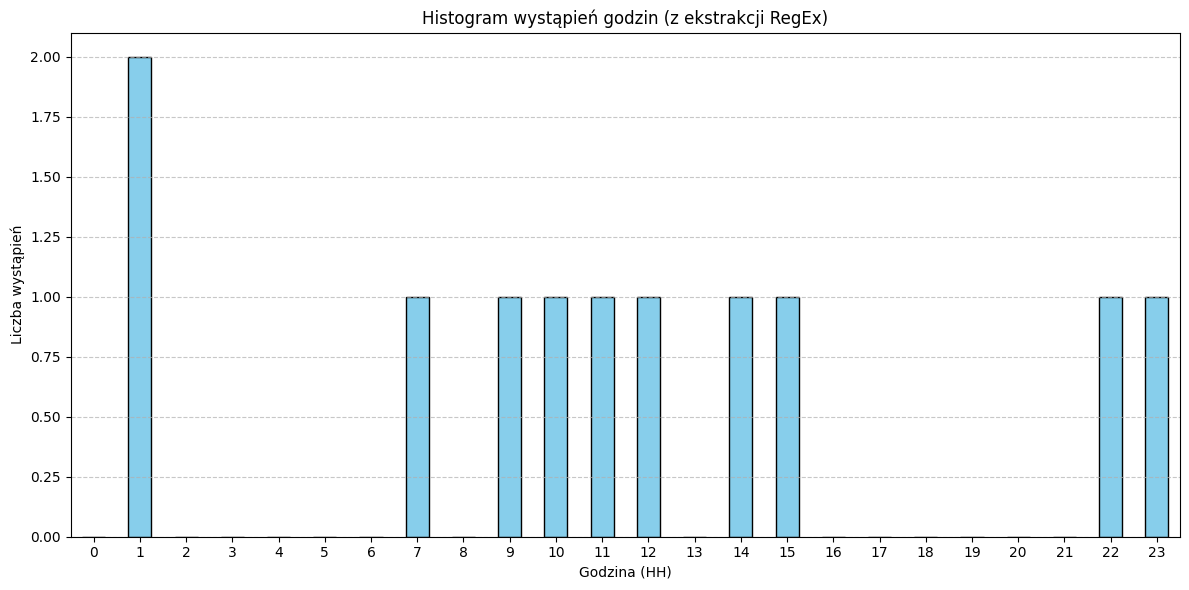

<Figure size 1200x600 with 0 Axes>

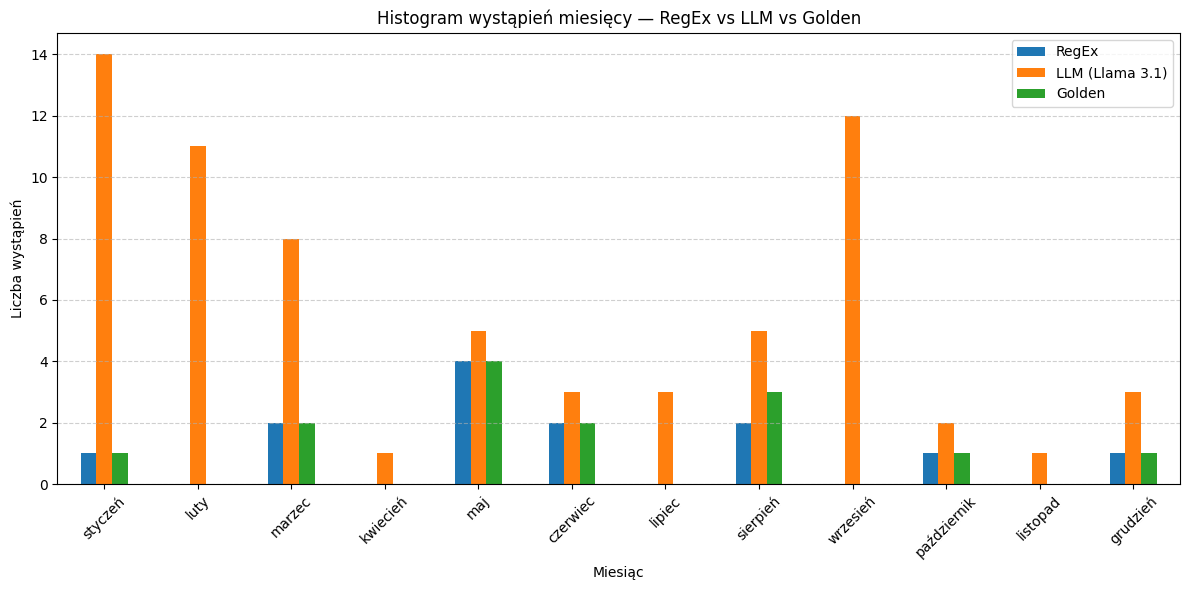

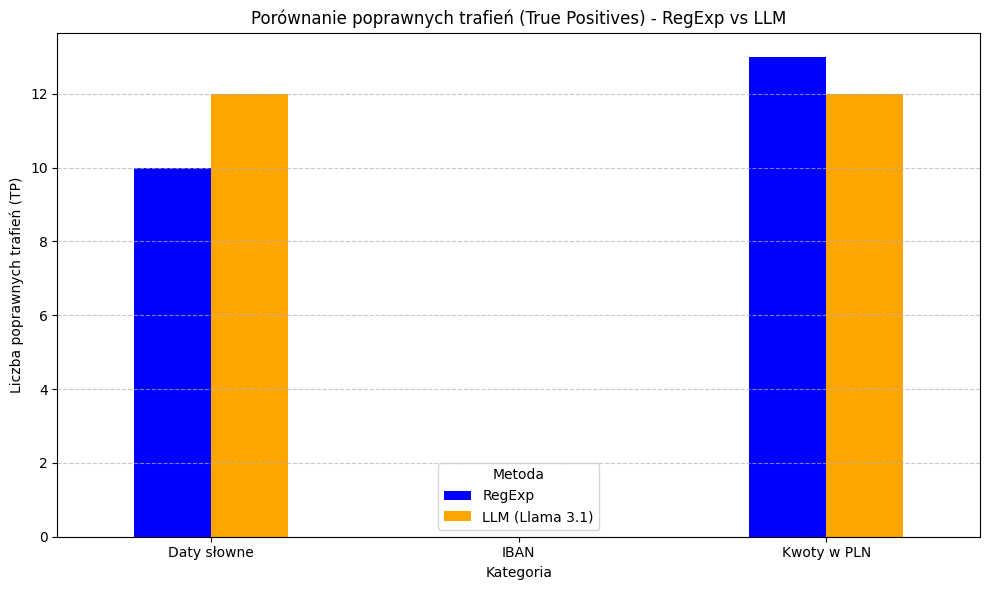

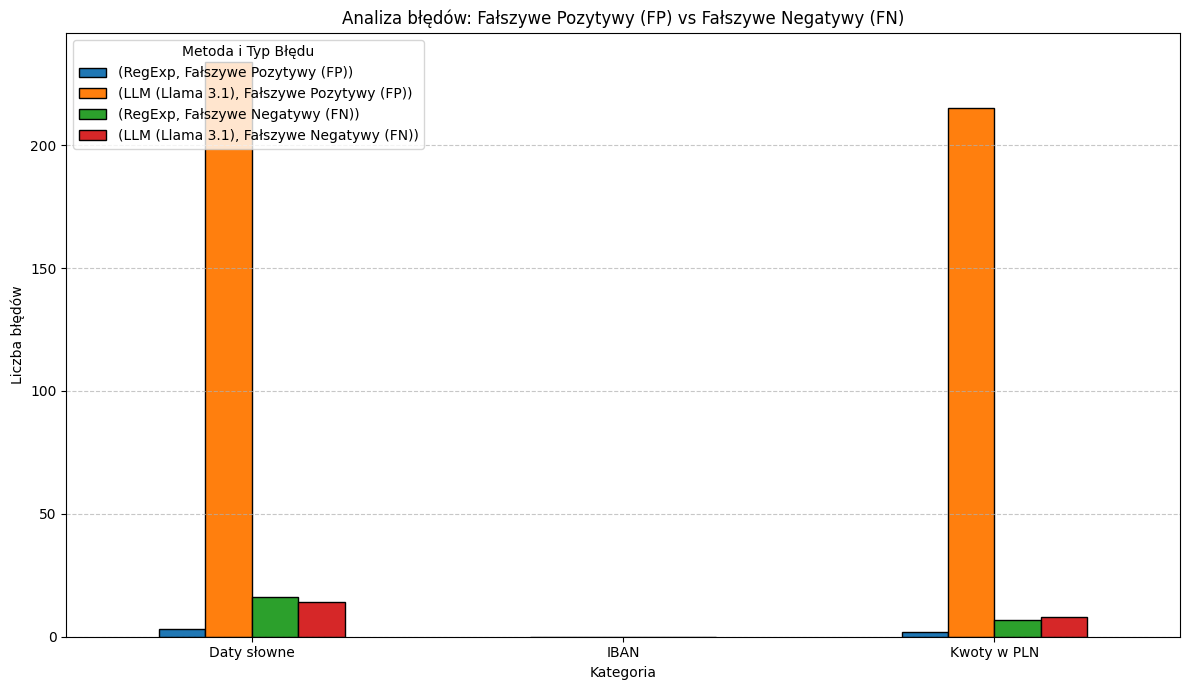

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools

def calculate_micro_metrics_all(dataset, gold_col, pred_col):
    """
    Oblicza sumy TP, FP, FN dla całego zbioru danych.
    """
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for row in dataset:
        gold_list = row[gold_col] if row[gold_col] is not None else []
        pred_list = row[pred_col] if row[pred_col] is not None else []

        try:
            G = set(tuple(item) if isinstance(item, list) else item for item in gold_list)
            P = set(tuple(item) if isinstance(item, list) else item for item in pred_list)
        except TypeError:
            G = set(gold_list)
            P = set(pred_list)
        
        total_tp += len(G & P)
        total_fp += len(P - G)
        total_fn += len(G - P)
            
    return {"tp": total_tp, "fp": total_fp, "fn": total_fn}

try:
    if 'evaluation_dataset' not in locals() or evaluation_dataset is None:
        raise NameError("Nie znaleziono 'evaluation_dataset'. Upewnij się, że ta zmienna istnieje.")
    
    print(f"Znaleziono 'evaluation_dataset' zawierający {len(evaluation_dataset)} próbek.")
    print("Generowanie histogramu godzin...")
    try:
        all_times = list(itertools.chain.from_iterable(evaluation_dataset['matched_datetimes']))
        hour_regex = re.compile(r"\b(\d{1,2}):\d{2}(?::\d{2})?\b")
        hours = [int(hour_regex.match(t).group(1)) for t in all_times if hour_regex.match(t)]
        
        df_hours = pd.DataFrame(hours, columns=['hour'])
        df_hours = df_hours[df_hours['hour'].between(0, 23)]
        hour_counts = df_hours['hour'].value_counts().reindex(range(24), fill_value=0).sort_index()
        
        plt.figure(figsize=(12, 6))
        hour_counts.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Histogram wystąpień godzin (z ekstrakcji RegEx)')
        plt.xlabel('Godzina (HH)')
        plt.ylabel('Liczba wystąpień')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('histogram_godzin.png')
        print("Zapisano 'histogram_godzin.png'")
    except Exception as e:
        print(f"Nie można wygenerować histogramu godzin: {e}")

    print("Generowanie histogramu miesięcy...")
    try:
        all_verbal_dates = list(itertools.chain.from_iterable(evaluation_dataset['matched_verbal_dates'])) if 'matched_verbal_dates' in evaluation_dataset.column_names else []
        all_verbal_dates_llama = list(itertools.chain.from_iterable(evaluation_dataset['llama3_verbal_dates'])) if 'llama3_verbal_dates' in evaluation_dataset.column_names else []
        all_verbal_dates_golden = list(itertools.chain.from_iterable(evaluation_dataset['golden_verbal_dates'])) if 'golden_verbal_dates' in evaluation_dataset.column_names else []

        month_map = {
            'stycznia': 'styczeń', 'styczeń': 'styczeń',
            'lutego': 'luty', 'luty': 'luty',
            'marca': 'marzec', 'marzec': 'marzec',
            'kwietnia': 'kwiecień', 'kwiecień': 'kwiecień',
            'maja': 'maj', 'maj': 'maj',
            'czerwca': 'czerwiec', 'czerwiec': 'czerwiec',
            'lipca': 'lipiec', 'lipiec': 'lipiec',
            'sierpnia': 'sierpień', 'sierpień': 'sierpień',
            'września': 'wrzesień', 'wrzesień': 'wrzesień',
            'października': 'październik', 'październik': 'październik',
            'listopada': 'listopad', 'listopad': 'listopad',
            'grudnia': 'grudzień', 'grudzień': 'grudzień',
        }

        month_regex = re.compile(f"({'|'.join(month_map.keys())})", re.IGNORECASE)

        def extract_normalized_months(list_of_dates):
            out = []
            for date_str in list_of_dates:
                m = month_regex.search(str(date_str))
                if m:
                    out.append(month_map[m.group(1).lower()])
            return out

        norm_regex = extract_normalized_months(all_verbal_dates)
        norm_llama = extract_normalized_months(all_verbal_dates_llama)
        norm_golden = extract_normalized_months(all_verbal_dates_golden)

        month_order = ['styczeń', 'luty', 'marzec', 'kwiecień', 'maj', 'czerwiec',
                       'lipiec', 'sierpień', 'wrzesień', 'październik', 'listopad', 'grudzień']

        counts_regex = pd.Series(norm_regex).value_counts().reindex(month_order, fill_value=0)
        counts_llama = pd.Series(norm_llama).value_counts().reindex(month_order, fill_value=0)
        counts_golden = pd.Series(norm_golden).value_counts().reindex(month_order, fill_value=0)

        df_months_combined = pd.DataFrame({
            'RegEx': counts_regex,
            'LLM (Llama 3.1)': counts_llama,
            'Golden': counts_golden
        })

        if not df_months_combined.empty:
            display(df_months_combined)
            plt.figure(figsize=(12, 6))
            df_months_combined.plot(kind='bar', figsize=(12,6), rot=45)
            plt.title('Histogram wystąpień miesięcy — RegEx vs LLM vs Golden')
            plt.xlabel('Miesiąc')
            plt.ylabel('Liczba wystąpień')
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig('histogram_miesiecy.png')
            print("Zapisano 'histogram_miesiecy.png'")
        else:
            print("Brak danych do wygenerowania histogramu miesięcy.")            

    except Exception as e:
        print(f"Nie można wygenerować histogramu miesięcy: {e}")

    print("Generowanie wykresu porównawczego TP...")
    
    tasks_to_plot = [
        ("Daty słowne", "verbal_dates"),
        ("IBAN", "iban"),
        ("Kwoty w PLN", "pln_amounts")
    ]
    
    plot_data = []
    
    for name, task_key in tasks_to_plot:
        gold_col = f"golden_{task_key}"
        regex_col = f"matched_{task_key}"
        llama_col = f"llama3_{task_key}"
        
        if gold_col not in evaluation_dataset.column_names:
            print(f"Pominięto wykres TP dla '{name}': brak kolumny '{gold_col}'")
            continue
            
        stats_regex = calculate_micro_metrics_all(evaluation_dataset, gold_col, regex_col)
        stats_llama = calculate_micro_metrics_all(evaluation_dataset, gold_col, llama_col)
        
        plot_data.append({"Kategoria": name, "Metoda": "RegExp", "Poprawne trafienia (TP)": stats_regex['tp']})
        plot_data.append({"Kategoria": name, "Metoda": "LLM (Llama 3.1)", "Poprawne trafienia (TP)": stats_llama['tp']})

    if plot_data:
        df_plot_tp = pd.DataFrame(plot_data)
        
        pivot_tp = df_plot_tp.pivot(index='Kategoria', columns='Metoda', values='Poprawne trafienia (TP)')
        
        if 'RegExp' in pivot_tp.columns and 'LLM (Llama 3.1)' in pivot_tp.columns:
            pivot_tp = pivot_tp[['RegExp', 'LLM (Llama 3.1)']]
        
        pivot_tp.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
        plt.title('Porównanie poprawnych trafień (True Positives) - RegExp vs LLM')
        plt.ylabel('Liczba poprawnych trafień (TP)')
        plt.xlabel('Kategoria')
        plt.xticks(rotation=0)
        plt.legend(title='Metoda')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('porownanie_poprawnych_trafien.png')
        print("Zapisano 'porownanie_poprawnych_trafien.png'")
    else:
        print("Nie wygenerowano wykresu TP z powodu braku danych.")
    
    print("Generowanie wykresu analizy błędów (FP / FN)...")
    
    error_data = []
    for name, task_key in tasks_to_plot:
        gold_col = f"golden_{task_key}"
        regex_col = f"matched_{task_key}"
        llama_col = f"llama3_{task_key}"

        if gold_col not in evaluation_dataset.column_names:
            print(f"Pominięto wykres błędów dla '{name}': brak kolumny '{gold_col}'")
            continue
            
        stats_regex = calculate_micro_metrics_all(evaluation_dataset, gold_col, regex_col)
        stats_llama = calculate_micro_metrics_all(evaluation_dataset, gold_col, llama_col)
        
        error_data.append({"Kategoria": name, "Metoda": "RegExp", "Typ błędu": "Fałszywe Pozytywy (FP)", "Liczba błędów": stats_regex['fp']})
        error_data.append({"Kategoria": name, "Metoda": "LLM (Llama 3.1)", "Typ błędu": "Fałszywe Pozytywy (FP)", "Liczba błędów": stats_llama['fp']})
        error_data.append({"Kategoria": name, "Metoda": "RegExp", "Typ błędu": "Fałszywe Negatywy (FN)", "Liczba błędów": stats_regex['fn']})
        error_data.append({"Kategoria": name, "Metoda": "LLM (Llama 3.1)", "Typ błędu": "Fałszywe Negatywy (FN)", "Liczba błędów": stats_llama['fn']})

    if error_data:
        df_errors = pd.DataFrame(error_data)
        
        pivot_errors = df_errors.pivot(index='Kategoria', columns=['Metoda', 'Typ błędu'], values='Liczba błędów')
        
        try:
            pivot_errors = pivot_errors.reindex(columns=[
                ('RegExp', 'Fałszywe Pozytywy (FP)'),
                ('LLM (Llama 3.1)', 'Fałszywe Pozytywy (FP)'),
                ('RegExp', 'Fałszywe Negatywy (FN)'),
                ('LLM (Llama 3.1)', 'Fałszywe Negatywy (FN)')
            ])
        except KeyError:
            print("Nie można posortować kolumn na wykresie błędów, używam domyślnej kolejności.")
        
        pivot_errors.plot(kind='bar', figsize=(12, 7), edgecolor='black')
        
        plt.title('Analiza błędów: Fałszywe Pozytywy (FP) vs Fałszywe Negatywy (FN)')
        plt.ylabel('Liczba błędów')
        plt.xlabel('Kategoria')
        plt.xticks(rotation=0)
        plt.legend(title='Metoda i Typ Błędu', loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('analiza_bledow_fp_fn.png')
        print("Zapisano 'analiza_bledow_fp_fn.png'")
    else:
        print("Nie wygenerowano wykresu błędów z powodu braku danych.")

except NameError as e:
    print(e)
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd podczas generowania wykresów: {e}")

In [106]:
print("--- Analiza Fałszywych Negatywów (FN) dla RegExp ---")
print("Pokazuję, co RegEx pominął, a co było w 'Złotym Standardzie'\n")

try:
    if 'evaluation_dataset' not in locals() or evaluation_dataset is None:
        raise NameError("Nie znaleziono 'evaluation_dataset'. Upewnij się, że ta zmienna istnieje.")
    
    tasks_to_check = [
        ("Daty słowne", "golden_verbal_dates", "matched_verbal_dates"),
        ("Kwoty w PLN", "golden_pln_amounts", "matched_pln_amounts"),
    ]

    for name, gold_col, regex_col in tasks_to_check:
        print(f"============================================================")
        print(f"Analiza FN dla: {name} (Kolumna RegEx: {regex_col})")
        print(f"============================================================")
        
        found_fn_count = 0
        found_fp_count = 0
        
        if gold_col not in evaluation_dataset.column_names:
            print(f"Pominięto: Brak kolumny '{gold_col}' w zbiorze.\n")
            continue
        if regex_col not in evaluation_dataset.column_names:
            print(f"Pominięto: Brak kolumny '{regex_col}' w zbiorze.\n")
            continue
            
        for i, row in enumerate(evaluation_dataset):
            gold_list = row[gold_col] if row[gold_col] is not None else []
            regex_list = row[regex_col] if row[regex_col] is not None else []
            
            gold_set = set(gold_list)
            regex_set = set(regex_list)
            
            false_negatives = gold_set - regex_set
            false_positives_regex = regex_set - gold_set
            
            if false_negatives or false_positives_regex:
                print(f"\n--- Próbka [Indeks {i}] ---")
                text_snippet = row['text'].replace('\n', ' ')[0:200]
                print(f"  Tekst (fragment): \"{text_snippet}...\"")

            if false_negatives:
                found_fn_count += 1
                
                print(f"  POMINIĘTE (FN): {list(false_negatives)}")
                print(f"  (RegEx znalazł: {list(regex_set)})")

            if false_positives_regex:
                found_fp_count += 1

                print(f"  Złoty Standard: {list(gold_set)}")
                print(f"  BŁĘDY RegExp (FP): {list(false_positives_regex)}")

                
        if found_fn_count == 0 and found_fp_count == 0:
            print("Nie znaleziono żadnych fałszywych negatywów i fałszywych pozytywów dla tej kategorii.")
        else:
            print(f"\nZnaleziono łącznie {found_fn_count} próbek z fałszywymi negatywami i {found_fp_count} próbek z fałszywymi pozytywami.")

except NameError as e:
    print(e)
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd: {e}")

--- Analiza Fałszywych Negatywów (FN) dla RegExp ---
Pokazuję, co RegEx pominął, a co było w 'Złotym Standardzie'

Analiza FN dla: Daty słowne (Kolumna RegEx: matched_verbal_dates)

--- Próbka [Indeks 5] ---
  Tekst (fragment): "sobota, 24.10.2020 14:19 8203 7 W sobotę 24 października około godziny 12.45 na drodze wojewódzkiej 382 na trasie Kamieniec Ząbkowicki -Paczków doszło do zderzenia busa i samochodu osobowego. Do czoło..."
  POMINIĘTE (FN): ['sobotę 24 października', 'sobota, 24.10.2020']
  (RegEx znalazł: ['24 października'])
  Złoty Standard: ['sobotę 24 października', 'sobota, 24.10.2020']
  BŁĘDY RegExp (FP): ['24 października']

--- Próbka [Indeks 20] ---
  Tekst (fragment): "9-letnia Emilka najlepsza w Europie! | Region Fakty Świebodziczanka Emilia Homenda wraz z swoim partnerem Michałem Michalskim zdobyła pierwsze miejsce w rankingu europejskim w tańcu towarzyskim, w kat..."
  POMINIĘTE (FN): ['roku 2017']
  (RegEx znalazł: [])

--- Próbka [Indeks 26] ---
  Tekst (fragmen

Po wstępnej analizie wyników, widzimy, że regexowi brakuje poprawek w kilku miejscach ale to da się poprawić aby wyłapywać to co chcemy zwłaszcza fleksje i dodatkowe dane jak dni tygodnia w datach. Modele LLM natomiast mają problem z halucynacją i to jest trudniejsze do poprawienia, wymagałoby to albo lepszego promptowania albo użycia innych modeli które lepiej radzą sobie z kontekstem.

## Wnioski i pytania końcowe

### Wzorce RegExp

Zalety: Wzorce były ekstremalnie szybkie (ok. 0.1s na kategorię dla 100 próbek) i miały wysoką precyzję (np. 0.867 dla PLN). W przypadku IBAN precyzja wyniosła 100% (0 trafień, 0 błędów). Mimo, że na wykresie obliczającym wyszło 0% precyzji dlatego, że nie było żadnych przykładów IBAN w tekście, to jednak precyzja pozostaje 100%.

Wady (FN): Miały niski Recall (np. 0.385 dla dat słownych), ponieważ nie były w stanie wyłapać elastycznych, nieprzewidzianych formatów (takie rzeczy jak fleksja jest dobrym przykładem), takich jak "1,5 do 3 tys. zł", które znalazły się w "złotym standardzie", czy też różne formy zapisu dat słownych z dniami tygodnia godzinami itp. 

### Prompty LLM

#### Daty Słowne:
```xml
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie daty zapisane słownie po polsku (np. DD miesiąc RRRR, miesiąc RRRR).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
<INPUT>...tekst...</INPUT>
<OUTPUT>
```

#### Kwoty w PLN:
```xml
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie kwoty pieniężne w polskich złotych (zakończone 'zł', 'PLN' lub 'złotych').
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma dopasowań, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
<INPUT>...tekst...</INPUT>
<OUTPUT>
```

#### Konto bankowe (NRB/IBAN):
```xml
<RULES>
1. ZADANIE: ZNAJDŹ wszystkie 26-cyfrowe numery kont bankowych (NRB/IBAN).
2. PRECYZJA: Ekstrahuj TYLKO wzorce, które DOSŁOWNIE znajdują się w tekście.
3. KATEGORYCZNIE NIE WYMYŚLAJ danych, których nie ma w tekście. To najważniejsza reguła.
</RULES>
<CONSTRAINT>
Jeśli w tekście nie ma ANI JEDNEGO 26-cyfrowego numeru, "matches" MUSI być pustą listą: [].
</CONSTRAINT>
<INPUT>...tekst...</INPUT>
<OUTPUT>
```

Ważne było, żeby użyć temperature=0 wraz z repeat_penalty=1.2 aby model nie powtarzał się i nie halucynował ani nie zacinał się. Ważne też było usunięcie przykładów z prompta, ponieważ modele miały tendencję do kopiowania tych przykładów zamiast faktycznej ekstrakcji wzorców z tekstu. Oczywiście modele halucynowały w mniejszym stopniu ale mimo wszystko sporo. Należało też do testów ograniczyć rozmiary analizowanych tekstów do 1000 znaków, ponieważ przy większych tekstach po prostu się zacinały. Mimo, że llama 3.1 8b jest znacznie lepszym modelem niż gemma2b to i tak znacznie wiecej halucynowała, widać to w przykładowych testach w zadnaiu z promptami. 

In [110]:
display(results_df)

,Kategoria,Metoda,Precision,Recall,F1,Czas_s
0,Daty słowne,RegExp,0.769,0.385,0.513,0.064
1,Daty słowne,LLM,0.049,0.462,0.088,43.000
2,IBAN,RegExp,0.000,0.000,0.000,0.056
3,IBAN,LLM,0.000,0.000,0.000,22.000
4,Kwoty w PLN,RegExp,0.867,0.650,0.743,0.056
5,Kwoty w PLN,LLM,0.053,0.600,0.097,33.000


Jak widać powyżej w datach precyzja wyniosła 0.769 a recall 0.385 gdzie dla LLMa precyzja miała 0.049 a recall 0.462. Czyli widzimy, że LLMy bardzo halucynują, ale calkiem nieźle wyłapują prawdziwe wzorce (recall). Ale to wylacznie kwestia tego, że RegExp nie wyłapał wszystkich elastycznych formatów, należałoby go poprawić wtedy recall by wzrósł znacznie, gdzie w przypadku LLmów ciężko coś poprawić bez zmiany modelu lub lepszego promptowania (co już jest trudne).

Fajne jest to, że w przypadku IBAN model nie halucynował, ale to jedyny przypadek gdzie tak było. (Ciężko powiedzieć czy dlatego, że nie było IBANów w tekście czy model faktycznie nie halucynował).

W przypadku kwot PLN sytuacja jest podobna jak z datami, RegEx ma wysoką precyzję i recall, natomiast LLM znowu halucynuje (niską precyzję), recall ma tym razem mniejszy ale zbliżony do RegExa, tu znowu nie są wyłapywane elastyczne formaty przez RegExa, które model potrafił znaleźć.


RegEx działa drastycznie lepiej. W kategoriach "Daty słowne" i "Kwoty w PLN", RegEx miał (7-8)-krotnie wyższy F1-score i był znacznie ale to znacznie szybszy niż Llama 3.1 8b. Atutem regexa jest to ze mozna to rozbic na kilka rdzeni i wtedy przelecenie nawet paru milionów tekstów jest bardzo szybkie, gdzie LLMy są z definicji wolniejsze i droższe w użyciu. (oczywiście zakładając, że mamy odpowiednie zasoby sprzętowe - RAM). Modele też powinno się dać zrównoleglić ale to już jest bardziej skomplikowane i wymaga więcej zasobów.

Wzorce "łatwe" vs "trudne": Wzorce "twarde" (IBAN, daty cyfrowe) są "łatwe" dla RegEx. Wzorce "miękkie" (daty słowne, kwoty słowne) są "trudne" dla RegEx (niski Recall). Dla Llama 3.1 8b wszystkie zadania ekstrakcji okazały się "trudne", ponieważ model nie potrafił powstrzymać się od halucynacji, co skutkowało tragiczną precyzją (ok. 5%).

**Wniosek**

Teoretycznie te co są nieznalezione przez RegExa można łatwo poprawić eksperymentując z wynikami. W tym akurat model się przydał moim zdaniem, znalazł przykłady które RegEx pominął. Może nawet połączenie 2 technik jest najlepsze ? Model do znalezienia elastycznych formatów a RegEx do szybkiego i precyzyjnego wyłapania wzorców, zwłaszcza tych wcześniej pominiętych.

### Odpowiedzi na pytania

1. Polskie znaki i fleksja: Modele (Llama/Gemma) poprawnie rozpoznawały słowa z diakrytykami (np. złotych). Problem leżał w precyzji: RegEx znajdował tylko te formy, które mu podaliśmy, podczas gdy Llama 3.1, mimo rozumienia fleksji, generowała przy tym tyle szumu (FP), że jej niska precyzja (5%) czyniła ją bezużyteczną. Ciężko ocenić czy w zadaniu z fleksją modele faktycznie coś znalazły, ponieważ naprawde sporo tam halucynowały, często po prostu przepisywały formy człowiek/ludzie z prompta zamiast faktycznie wyłapywać wzorce z tekstu.


2. Deterministyczność: temperature=0 jest kluczowe. W testach rzeczywiście zdarzało się, że halucynowało na poziomie 99% znajdowanych (JAKICHKOLWIEK) wzorców gdzie wcale tyle nie było (w niektórych zadaniach), aczkolwiek nie uważam, że to naprawde poprawiało sytuację, ponieważ i tak precyzja była tragiczna. Repeat_penalty=1.2 pomagało unikać powtórzeń w generowanym wyjściu, aczkolwiek długość tekstu jest kluczowa, żeby się model nie zacinał. Ale ostatecznie temperature=0 zmniejszyła halucynacje wraz z wymuszeniem schematu JSON.

3. Precyzja vs. Uogólnienie:

    RegEx pokazał wysoką precyzję (P=~0.8), ale niski/średni recall (R=~0.4-0.6). Był precyzyjny, ale gubił rzadkie przypadki (False Negatives), np. nie znalazł "1,5 do 3 tys. zł".

    Llama 3.1 8b uogólniała zbyt mocno (FP - False Positives), co dało katastrofalną precyzję (P=~0.05). Model generował masę halucynacji, a jego Recall wcale nie był znacząco lepszy od RegEx.

4. Odporność na szum: LLM teoretycznie rozumie literówki (500 zl vs zł), ale w praktyce wprowadził znacznie więcej "szumu" (halucynacji) niż rozwiązał problemów. Ciekawe jest to, że gemma2:2b generował mniej szumu niż llama 3.1 8b. Nie uwzględniłem go w ostatecznych testach, ale było to widoczne w eksperymentach.

5. Skalowanie z długością: To był krytyczny problem. Mniejsze modele (gemma2:2b) całkowicie zawieszały się na długich tekstach (>1k znaków), oczywiście nie każdy tekst, ale długość 1k znaków była bezpiecznym limitem. Llama 3.1 8b była stabilniejsza (choć również się zacinała w niektórych przypadkach), ale jej skłonność do halucynacji rosła wraz z długością tekstu.

6. Formatowanie wyjścia (JSON): Llama 3.1 8b działała idealnie (100% poprawnych JSON-ów) dzięki `format=ExtractionResponse.model_json_schema()`, `temperature=0` i promptom XML. Gemma 2 2b jak i pozniej Llama 3.1 8b okazała się niestabilna, ponieważ się zacinała bez odpowiednich ustawień (prompt + temperature=0 + repeat_penalty=1.2) oraz `<OUTPUT>` tagów w promptach oraz długości tekstu wejściowego.

7. Transfer między kategoriami: Transfer był bardzo łatwy. Struktura promptu XML (`<RULES>`) działała troche jak szablon. Zmiana zadania z IBAN na Kwoty PLN wymagała jedynie zmiany tekstu w `<RULES>`. Model nie powinien móc mylić kategorii, ponieważ prompty były niezależnie puszczane dla każdej kategorii.

8. Llama vs. Gemma (Jakość/Prędkość):

    Gemma 2b (mniejszy model) była całkowicie niestabilna i bezużyteczna; zawieszała się na niektórych danych dlatego też nie uwzględniłem jej w ostatecznych testach. Chociaż może warto było zweryfikować recall tego modelu dla testu. 

    Llama 3.1 8b (większy model) była stabilniejsza, ale cierpiała na katastrofalną precyzję (5%) w zadaniach ekstrakcji.

## Podsumowanie

Co bym wybrał ?
- RegExp: Do zadań ekstracji danych o wyskoiej precyzji (IBAN, e-mail, daty cyfrowe, PLN)
- LLM: Model nie okazał się przydatny do tego zadania z powodu precyzji najzwyczaniej. Mógłby być używany do prostych zadań jak kategoryzacja tematów itd.

Czyli ostatecznie RegExp'a

Natomiast widzę potencjał w połączeniu obu technik, gdzie RegExp wyłapuje to co potrafi z wysoką precyzją, albo to co nam się wydaje jak poprawne na pierwszy rzut oka, a LLM mógłby być użyty do znalezienia elastycznych formatów które RegExp pominął.

Rozbiłym to na 3 kroki:
1. Uzycie RegEx do ekstrakcji wzorców "twardych" z wysoką precyzją, do których regex jest dobrze dostosowany.
2. Użycie LLM do ekstrakcji wzorców "miękkich" lub elastycznych formatów, które RegEx pominął. 
3. Walidacja wyników LLM, uwzględnienie brakujących wzorców w RegEx i ewentualne poprawki RegEx na podstawie wyników LLM. 

Są jeszcze przykłady gdzie RegEx może się nie nadawać a LLM już tak, np. ekstrakcja wzorców słownych takich jak `jeden milion złotych` itp. gdzie RegEx nie jest w stanie sobie poradzić, a LLM mógłby to zrobić lepiej. Wtedy dodatkowym krokiem byłoby:

4. Użycie LLM do ekstrakcji wzorców słownych (np. kwoty słowne) i integracja ich z wynikami RegEx i LLM z kroków 1-3. Niestety to trzebaby robić pewnie ręcznie, chyba że udałoby się to zautomatyzować w jakiś sposób.